In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer

In [3]:
tl_core = 20.
tl_gap = 12.
tl_ground = 10.

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [4]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

def draw_single_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, open_length):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed enfd of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,restricted_scale=400, constant_scale=900, radius=0)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])


    # 10. Create closed meander of resonator
    open_end_resonator = elements.CPW(name='open end resonator', points=[fanout_for_open_end.get_terminals()['down'].position, 
                                                                         (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                          fanout_for_open_end.get_terminals()['down'].position[1]-open_length)],
                                      w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                      g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator)
    sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator, 'port1', 0)))

    # 11. Create grounding of resonator
    resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2

In [5]:
def draw_double_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1, open_length1, closed_end_meander_length2, open_length2):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length1,restricted_scale=400, constant_scale=900, radius=0)
    
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1='down',
                                                meander_length=closed_end_meander_length2,restricted_scale=400, constant_scale=900, radius=0)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1), (3,4)])

    # 10. Create closed meander of resonator
    open_end_resonator1 = elements.CPW(name='open end resonator 1', points=[fanout_for_open_end.get_terminals()['down'].position, 
                                                                         (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                          fanout_for_open_end.get_terminals()['down'].position[1]-open_length1)],
                                      w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                      g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator1)
    sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator1, 'port1', 0)))
    sample.open_end(open_end_resonator1, 'port2', 'open end1')
    
    open_end_resonator2 = elements.CPW(name='open end resonator 2', points=[fanout_for_open_end.get_terminals()['up'].position, 
                                                                         (fanout_for_open_end.get_terminals()['up'].position[0],
                                                                          fanout_for_open_end.get_terminals()['up'].position[1]+open_length2)],
                                      w=fanout_for_open_end.get_terminals()['up'].w, s=fanout_for_open_end.get_terminals()['up'].s,
                                      g=fanout_for_open_end.get_terminals()['up'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator2)
    sample.connections.append(((fanout_for_open_end, 'up', 0), (open_end_resonator2, 'port1', 0)))
    sample.open_end(open_end_resonator2, 'port2', 'open end2')

    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2

In [6]:
#g1, g2 = draw_single_resonator(coupler_start, central_line_y, coupler_length,
#                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
#                         closed_end_meander_length=2300, open_length=1000)
g1, g2 = draw_double_resonator(coupler_start, central_line_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                         closed_end_meander_length1=2300, open_length1=1000, 
                         closed_end_meander_length2=2400, open_length2=1100)

g3, g4 = draw_double_resonator(coupler_start+2000, central_line_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                         closed_end_meander_length1=2500, open_length1=1000, 
                         closed_end_meander_length2=2600, open_length2=1100)

# 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])

middle_TL = sample.connect_cpw(o1=g2, o2=g3, port1='narrow', port2='narrow', name='center TL', points=[])
# 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g4, port1='port', port2='narrow', name='right TL', points=[])

In [7]:
design = sample.draw_design()
watch()

/home/alena/anaconda3/lib/python3.7/site-packages/gdspy/path.py:828: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  "[GDSPY] Possible inconsistency found in "
/home/alena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  """Entry point for launching an IPython kernel.


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [7]:
sample.connections

[((CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 0),
  (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 0)),
 ((CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 1),
  (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 1)),
 ((CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 2),
  (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 2)),
 ((CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 3),
  (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 3)),
 ((CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 4),
  (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 4)),
 ((RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'center', 0),
  (RectGrounding cl1, 'wide', 0)),
 ((RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'center', 1),
  (RectGrounding cl1, 'wide', 1)),
 ((RectFanout closed end resonator fanout, n=5,

In [8]:
sample.objects

 CPWCoupler "TL-resonator coupler", n=5, l=299.760,
 RectFanout closed end resonator fanout, n=5, grouping=(1, 4),
 RectGrounding cl1,
 CPW "closed end 1", l=2299.958,
 CPW "closed end 2", l=2399.958,
 RectFanout open end resonator fanout, n=5, grouping=(1, 4),
 RectGrounding cl2,
 CPW "open end resonator 1", l=999.933,
 CPW "open end resonator 2", l=1099.933,
 RectGrounding resonator ground 1,
 RectGrounding resonator ground 2,
 CPWCoupler "TL-resonator coupler", n=5, l=299.760,
 RectFanout closed end resonator fanout, n=5, grouping=(1, 4),
 RectGrounding cl1,
 CPW "closed end 1", l=2299.958,
 CPW "closed end 2", l=2399.958,
 RectFanout open end resonator fanout, n=5, grouping=(1, 4),
 RectGrounding cl2,
 CPW "open end resonator 1", l=999.933,
 CPW "open end resonator 2", l=1099.933,
 RectGrounding resonator ground 1,
 RectGrounding resonator ground 2,
 CPW "left TL", l=967.808,
 CPW "center TL", l=1635.808,
 CPW "right TL", l=4367.808]

In [21]:
design = sample.draw_design()
watch()

<ipython-input-2-1fe8b7b94d80>:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [10]:
gdspy.write_gds('1qubit.gds', cells=None, name='library', unit=1e-06, precision=1e-09, timestamp=None, binary_cells=None)

In [11]:
resonator_ground

16

In [8]:
sys, connections, elements_ = sample.get_tls()

In [13]:
sys.terminal_node_mapping

[[45],
 [49],
 [1, 2, 3, 4, 5, 11, 12, 13, 14, 15],
 [1, 10],
 [2, 3, 4, 6, 7, 8],
 [5, 9],
 [6, 0],
 [8, 0],
 [7, 46],
 [9, 21],
 [10, 22],
 [15, 19],
 [14, 13, 12, 16, 17, 18],
 [11, 20],
 [16, 0],
 [18, 0],
 [17, 47],
 [19, 51],
 [20, 52],
 [21],
 [22],
 [23, 24, 25, 26, 27, 33, 34, 35, 36, 37],
 [23, 32],
 [24, 25, 26, 28, 29, 30],
 [27, 31],
 [28, 0],
 [30, 0],
 [29, 48],
 [31, 43],
 [32, 44],
 [37, 41],
 [36, 35, 34, 38, 39, 40],
 [33, 42],
 [38, 0],
 [40, 0],
 [39, 50],
 [41, 53],
 [42, 54],
 [43],
 [44],
 [45, 46],
 [47, 48],
 [49, 50]]

In [14]:
connections

{(CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 0): 1,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 0): 1,
 (CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 1): 2,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 1): 2,
 (CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 2): 3,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 2): 3,
 (CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 3): 4,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 3): 4,
 (CPWCoupler "TL-resonator coupler", n=5, l=299.760, 'port1', 4): 5,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4), 'wide', 4): 5,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4),
  'center',
  0): 6,
 (RectGrounding cl1, 'wide', 0): 6,
 (RectFanout closed end resonator fanout, n=5, grouping=(1, 4),
  'center',
  1): 7,
 (RectGrounding cl1, 'wide', 1): 7,
 (RectFanout close

In [15]:
elements_

{'chip_edge_ground': [],
 'p1': [Port p1],
 'p2': [Port p2],
 'TL-resonator coupler': [TL TL-resonator coupler (n=5)],
 'closed end resonator fanout': [TL closed end resonator fanout_group0 (n=1),
  TL closed end resonator fanout_group1 (n=3),
  TL closed end resonator fanout_group2 (n=1)],
 'cl1': [[R cl10, R cl11, TL cl1 (n=1)]],
 'closed end 1': [TL closed end 1 (n=1)],
 'closed end 2': [TL closed end 2 (n=1)],
 'open end resonator fanout': [TL open end resonator fanout_group0 (n=1),
  TL open end resonator fanout_group1 (n=3),
  TL open end resonator fanout_group2 (n=1)],
 'cl2': [[R cl20, R cl21, TL cl2 (n=1)]],
 'open end resonator 1': [TL open end resonator 1 (n=1)],
 'open end resonator 2': [TL open end resonator 2 (n=1)],
 'resonator ground 1': [Short ],
 'resonator ground 2': [Short ],
 'left TL': [TL left TL (n=1)],
 'center TL': [TL center TL (n=1)],
 'right TL': [TL right TL (n=1)]}

../QCreator/general_sample_creator.py:350: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


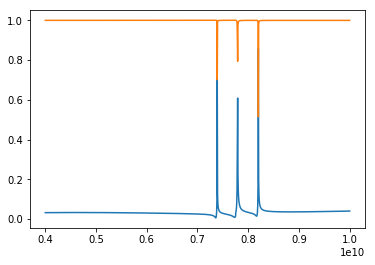

In [9]:
f_ = np.linspace(4e9, 10e9, 1001)
s11 = sample.get_s21('p1', 'p1', f_)
s21 = sample.get_s21('p1', 'p2', f_)
from matplotlib import pyplot as plt
plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s21))

In [10]:
%matplotlib qt

In [11]:
f_ = np.linspace(4e9, 10e9, 1001)
plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s21))

In [17]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f[:10]/(2*np.pi), delta[:10]

(array([7.76986791e+09, 7.79718837e+09, 8.19402896e+09, 8.22977067e+09,
        8.27628229e+09, 1.64112271e+10, 2.32610903e+10, 2.32622015e+10,
        2.38225021e+10, 2.45298274e+10]),
 array([1.83940633e+05, 8.54668033e+06, 2.37205695e+05, 1.33619819e+07,
        7.01824400e+10, 7.10427558e+10, 1.00877294e+07, 1.26986384e+06,
        7.29161776e+10, 1.09593813e+07]))